# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [1]:
# Import necessary libraries and modules

import time  # For time-related functions
import pandas as pd  # For data manipulation
import matplotlib.pyplot as plt  # For data visualization
from tqdm import tqdm  # For progress bar

import torch  # For PyTorch deep learning framework
from torch.utils.data import DataLoader  # For data loading

from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.model_selection import KFold  # For data splitting

# Import custom utility functions
from common_utils import set_seed, split_dataset, EarlyStopper, train_one_epoch, evaluate_model

# Set a specific random seed for reproducibility
SEED = 0
set_seed(SEED)

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn

3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [3]:
# Loading the dataset from a CSV file.
df = pd.read_csv('simplified.csv')
set_seed()

# Extracting the 'label' from the 'filename' column.
# It appears the label is embedded in the filename and is the penultimate (second last) item when split by '_'.
df['label'] = df['filename'].str.split('_').str[-2]

# Checking the distribution of the labels.
print(df['label'].value_counts())

# Dropping Unnecessary Columns and Splitting the Dataset:
# The dataset column called filename is likely a unique identifier for each sample and not a feature we would use for modeling. Hence, we should remove it before feeding the data to our model. 
columns_to_drop = ['filename', 'label']  

# Splitting the dataset into training and testing sets:
# The split is done in a 70:30 ratio, and the random_state ensures reproducibility.
# We still do train-test split here because the question specifies us to use 5-fold cross-validation on the training partition and not the whole dataset.
X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=SEED)

'''
In the context of 5-fold cross-validation, "reconsidering the scaling" likely means we should be applying scaling within each fold of the cross-validation, rather than fitting a scaler on the entire training dataset beforehand. 
In each fold of the 5-fold cross-validation, a portion of our training set becomes the "validation" set, so the scaling parameters might be slightly different for each fold.

As such, for our k-fold cross-validation procedure, the steps would be as follows:

The original training dataset is split into k subsets (folds).
For each k:
    Take the k-th fold as the validation set, and the remaining k-1 folds as the training set.
    Fit the scaler only on this new training set.
    Transform both the training and validation sets using this scaler.
    Train the model on the scaled training set.
    Validate the model on the scaled validation set.
'''

def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # Dictionary Initializations
    X_train_scaled_dict = {}  # Dictionary to store scaled training data
    X_val_scaled_dict = {}    # Dictionary to store scaled validation data
    y_train_dict = {}         # Dictionary to store training labels
    y_val_dict = {}           # Dictionary to store validation labels

    # Create a 5-fold cross-validation object with shuffling
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

    # Loop through different batch sizes
    for batch_size in parameters:
        X_train_scaled_folds = []  # List to store scaled training data for each fold
        X_val_scaled_folds = []    # List to store scaled validation data for each fold
        y_train_folds = []         # List to store training labels for each fold
        y_val_folds = []           # List to store validation labels for each fold

        # Loop through each fold
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
            X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

            # Scaling the data using StandardScaler
            scaler = StandardScaler()
            X_train_fold_scaled = scaler.fit_transform(X_train_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)

            # Append data to respective lists
            X_train_scaled_folds.append(X_train_fold_scaled)
            X_val_scaled_folds.append(X_val_fold_scaled)
            y_train_folds.append(y_train_fold)
            y_val_folds.append(y_val_fold)

        # Store data for this batch size in dictionaries
        X_train_scaled_dict[batch_size] = X_train_scaled_folds
        X_val_scaled_dict[batch_size] = X_val_scaled_folds
        y_train_dict[batch_size] = y_train_folds
        y_val_dict[batch_size] = y_val_folds

    # Return the dictionaries containing data for different batch sizes
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

set_seed(SEED)  # Set a specific random seed for reproducibility
batch_sizes = [128, 256, 512, 1024]  # List of batch sizes to generate folds for
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)


label
pos    6202
neg    5855
Name: count, dtype: int64


In [4]:
# Dictionaries to hold the DataLoaders for training and validation datasets for each batch size.
set_seed(SEED)
train_loaders_dict = {}
val_loaders_dict = {}

# Loop through each batch size we're considering
for batch_size in batch_sizes:
    
    # Lists to store DataLoaders for the current batch size for each of the 5 folds
    train_loaders = []
    val_loaders = []

    # Loop through each fold (0 through 4 for 5-fold CV)
    for i in range(5):
        
        # Create a PyTorch Dataset for the training data for the current fold. The CustomDataset will convert our data into a format that PyTorch can work with.
        train_dataset = CustomDataset(X_train_scaled_dict[batch_size][i], y_train_dict[batch_size][i])
        
        # Similarly, create a PyTorch Dataset for the validation data for the current fold.
        val_dataset = CustomDataset(X_val_scaled_dict[batch_size][i], y_val_dict[batch_size][i])

        # Create a DataLoader for the training dataset. This DataLoader will allow us to efficiently iterate over data in mini-batches of size 'batch_size'.
        # We shuffle the training data to ensure the order is different each epoch.
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # Create a DataLoader for the validation dataset. There's no need to shuffle validation data as we typically just evaluate performance on it.
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Append the created DataLoaders to our lists.
        train_loaders.append(train_loader)
        val_loaders.append(val_loader)

    # Store the lists of DataLoaders in our dictionaries with the current batch size as the key. This way, when we need to access the DataLoader for a specific fold and batch size, we can easily retrieve it.
    train_loaders_dict[batch_size] = train_loaders
    val_loaders_dict[batch_size] = val_loaders

4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [5]:
def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, hyperparameter_name):
    
    # Initialize dictionaries to store results
    cross_validation_accuracies = {size: [] for size in batch_sizes}
    cross_validation_times = {size: [] for size in batch_sizes}
    
    # Define the loss function for training
    loss_function = loss_fn
    
    # Get the number of input features from the first batch of the first fold
    no_features = X_train_scaled_dict[batch_sizes[0]][0].shape[1]
    
    # Define the number of hidden units in the neural network
    no_hidden = 128
    
    # Define the number of output labels (binary classification)
    no_labels = 1
    
    # Define other hyperparameters
    num_folds = 5
    num_epochs = 100
    learning_rate = 0.001
    
    # Iterate through each batch size
    for batch_size in batch_sizes:
        print(f"========== Starting with {hyperparameter_name}: {batch_size} ==========")
        
        # Iterate through each fold (5-fold cross-validation)
        for i in range(num_folds):
            
            # Create a neural network model
            model = MLP(no_features, no_hidden, no_labels)
            
            # Define the optimizer with a specified learning rate
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            
            # Get the training and validation data loaders for the current batch size and fold
            train_loader = train_loaders_dict[batch_size][i]
            val_loader = val_loaders_dict[batch_size][i]
            
            # Initialize an EarlyStopper object to monitor early stopping
            early_stopper = EarlyStopper(patience=3)
            
            # Loop through the specified number of training epochs
            for epoch in tqdm(range(num_epochs)):
                start_time = time.time()
                
                # Train the model for one epoch and compute the training loss
                train_loss = train_one_epoch(model, train_loader, optimizer, loss_function)
                
                # Evaluate the model on the validation set and compute accuracy AND loss
                val_accuracy, val_loss = evaluate_model(model, val_loader, loss_function)
                
                # Calculate the time taken for this epoch
                end_time = time.time()
                last_epoch_time = end_time - start_time
                
                # Check for early stopping based on validation loss
                if early_stopper.early_stop(val_loss):
                    print(f"Early stopping at epoch {epoch + 1} during fold {i + 1}")
                    break

            
            # Store the time taken for the last epoch for this fold
            cross_validation_times[batch_size].append(last_epoch_time)
            
            # Store the validation accuracy for this fold
            cross_validation_accuracies[batch_size].append(val_accuracy)
            
            # Print the results for this fold
            print(f"Fold {i + 1} Last Epoch - Accuracy: {round(val_accuracy,4)}, Time: {round(last_epoch_time,4)} seconds")
        
        print()
        # Calculate and print the mean cross-validation accuracy + mean time taken for last epoch for this batch size
        mean_accuracy = sum(cross_validation_accuracies[batch_size]) / len(cross_validation_accuracies[batch_size])
        mean_time = sum(cross_validation_times[batch_size]) / len(cross_validation_times[batch_size])
        print(f"Batch size {batch_size}'s Last Epoch - Mean Accuracy: {round(mean_accuracy,4)}, Mean Time: {round(mean_time,4)} seconds")
        print()
        
    return cross_validation_accuracies, cross_validation_times

set_seed(SEED)

batch_sizes = [128, 256, 512, 1024]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')

# Prepare for plotting
batch_sizes_list = list(cross_validation_accuracies.keys())
mean_cv_accuracies = [round(sum(cross_validation_accuracies[batch_size]) / len(cross_validation_accuracies[batch_size]),4) for batch_size in batch_sizes_list]

# Create a dataframe for mean cross validation accuracies against batch sizes
cv_accuracies_df = pd.DataFrame({
    'Batch Size': batch_sizes_list,
    'Mean Cross-Validation Accuracy On Final Epoch': mean_cv_accuracies
})

print("Mean Cross-Validation Accuracy On Final Epoch Against Different Batch Sizes:")
print()
display(cv_accuracies_df)


========== Starting with batch_size: 128 ==========


 17%|█▋        | 17/100 [00:06<00:33,  2.49it/s]


Early stopping at epoch 18 during fold 1
Fold 1 Last Epoch - Accuracy: 0.7115, Time: 0.3646 seconds


 29%|██▉       | 29/100 [00:14<00:36,  1.96it/s]


Early stopping at epoch 30 during fold 2
Fold 2 Last Epoch - Accuracy: 0.7488, Time: 0.5045 seconds


 17%|█▋        | 17/100 [00:08<00:42,  1.95it/s]


Early stopping at epoch 18 during fold 3
Fold 3 Last Epoch - Accuracy: 0.6943, Time: 0.3 seconds


 24%|██▍       | 24/100 [00:09<00:31,  2.40it/s]


Early stopping at epoch 25 during fold 4
Fold 4 Last Epoch - Accuracy: 0.7316, Time: 0.5443 seconds


 18%|█▊        | 18/100 [00:06<00:31,  2.58it/s]


Early stopping at epoch 19 during fold 5
Fold 5 Last Epoch - Accuracy: 0.7172, Time: 0.312 seconds

Batch size 128's Last Epoch - Mean Accuracy: 0.7207, Mean Time: 0.4051 seconds

========== Starting with batch_size: 256 ==========


 27%|██▋       | 27/100 [00:07<00:19,  3.71it/s]


Early stopping at epoch 28 during fold 1
Fold 1 Last Epoch - Accuracy: 0.7393, Time: 0.3703 seconds


 38%|███▊      | 38/100 [00:09<00:16,  3.87it/s]


Early stopping at epoch 39 during fold 2
Fold 2 Last Epoch - Accuracy: 0.7553, Time: 0.2324 seconds


 33%|███▎      | 33/100 [00:08<00:17,  3.90it/s]


Early stopping at epoch 34 during fold 3
Fold 3 Last Epoch - Accuracy: 0.7453, Time: 0.2238 seconds


 24%|██▍       | 24/100 [00:06<00:19,  3.89it/s]


Early stopping at epoch 25 during fold 4
Fold 4 Last Epoch - Accuracy: 0.7073, Time: 0.3654 seconds


 29%|██▉       | 29/100 [00:07<00:18,  3.91it/s]


Early stopping at epoch 30 during fold 5
Fold 5 Last Epoch - Accuracy: 0.7463, Time: 0.2199 seconds

Batch size 256's Last Epoch - Mean Accuracy: 0.7387, Mean Time: 0.2824 seconds

========== Starting with batch_size: 512 ==========


 29%|██▉       | 29/100 [00:05<00:14,  4.96it/s]


Early stopping at epoch 30 during fold 1
Fold 1 Last Epoch - Accuracy: 0.7002, Time: 0.1943 seconds


 32%|███▏      | 32/100 [00:06<00:13,  4.90it/s]


Early stopping at epoch 33 during fold 2
Fold 2 Last Epoch - Accuracy: 0.7305, Time: 0.1919 seconds


 27%|██▋       | 27/100 [00:05<00:14,  5.02it/s]


Early stopping at epoch 28 during fold 3
Fold 3 Last Epoch - Accuracy: 0.7073, Time: 0.1784 seconds


 27%|██▋       | 27/100 [00:05<00:15,  4.63it/s]


Early stopping at epoch 28 during fold 4
Fold 4 Last Epoch - Accuracy: 0.7073, Time: 0.2571 seconds


 31%|███       | 31/100 [00:08<00:18,  3.72it/s]


Early stopping at epoch 32 during fold 5
Fold 5 Last Epoch - Accuracy: 0.7267, Time: 0.2576 seconds

Batch size 512's Last Epoch - Mean Accuracy: 0.7144, Mean Time: 0.2159 seconds

========== Starting with batch_size: 1024 ==========


 35%|███▌      | 35/100 [00:08<00:15,  4.11it/s]


Early stopping at epoch 36 during fold 1
Fold 1 Last Epoch - Accuracy: 0.7257, Time: 0.1927 seconds


 29%|██▉       | 29/100 [00:05<00:14,  4.99it/s]


Early stopping at epoch 30 during fold 2
Fold 2 Last Epoch - Accuracy: 0.6949, Time: 0.2013 seconds


 41%|████      | 41/100 [00:09<00:13,  4.29it/s]


Early stopping at epoch 42 during fold 3
Fold 3 Last Epoch - Accuracy: 0.7263, Time: 0.245 seconds


 40%|████      | 40/100 [00:08<00:12,  4.64it/s]


Early stopping at epoch 41 during fold 4
Fold 4 Last Epoch - Accuracy: 0.7133, Time: 0.1645 seconds


 36%|███▌      | 36/100 [00:06<00:12,  5.29it/s]

Early stopping at epoch 37 during fold 5
Fold 5 Last Epoch - Accuracy: 0.7244, Time: 0.166 seconds

Batch size 1024's Last Epoch - Mean Accuracy: 0.7169, Mean Time: 0.1939 seconds

Mean Cross-Validation Accuracy On Final Epoch Against Different Batch Sizes:



,Batch Size,Mean Cross-Validation Accuracy On Final Epoch
0,128,0.7207
1,256,0.7387
2,512,0.7144
3,1024,0.7169


5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

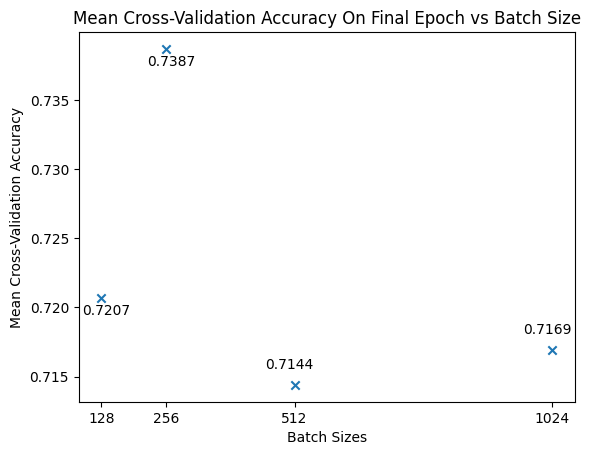

In [6]:
# Plot mean cross-validation accuracies on the final epoch for different batch sizes
plt.scatter(batch_sizes_list, mean_cv_accuracies, marker='x')
plt.xlabel('Batch Sizes')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Mean Cross-Validation Accuracy On Final Epoch vs Batch Size')
plt.xticks(batch_sizes_list)

# Add labels to each data point
for i, txt in enumerate(mean_cv_accuracies):
    if i == 2 or i == 3:
        plt.text(batch_sizes_list[i] - 10, mean_cv_accuracies[i] + 0.0012, round(txt, 4), ha='center')  
    else:
        plt.text(batch_sizes_list[i] + 10, mean_cv_accuracies[i] - 0.0012, round(txt, 4), ha='center')
plt.show()

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [7]:
# Please note that the next time you run this notebook cell, the results will be different as time taken depends on CPU speed and other factors.

# Calculate mean time for the last epoch for each batch size
mean_last_epoch_times_list = [round(sum(cross_validation_times[batch_size]) / len(cross_validation_times[batch_size]),4) for batch_size in batch_sizes_list]

# Create a table of time taken to train the network on the last epoch against different batch sizes
time_df = pd.DataFrame({
    'Batch Size': batch_sizes_list,
    'Mean Time Taken for Last Epoch Across 5 Folds (seconds)': mean_last_epoch_times_list
})

print("Mean Time Taken to Train the Network on the Last Epoch Across 5 Folds Against Different Batch Sizes:")
print()
display(time_df)


Mean Time Taken to Train the Network on the Last Epoch Across 5 Folds Against Different Batch Sizes:



,Batch Size,Mean Time Taken for Last Epoch Across 5 Folds (seconds)
0,128,0.4051
1,256,0.2824
2,512,0.2159
3,1024,0.1939


In [8]:
# YOUR CODE HERE
optimal_batch_size = 256
reason = '''

Given the balance of accuracy and speed, the Batch Size of 256 emerges as the optimal choice.

Selection of Optimal Batch Size:

    • Selecting the appropriate batch size is a crucial step in the optimization of neural networks. The goal is to find an equilibrium that harmonizes both computational efficiency 
    and model accuracy. Intuitively, as batch size increases, training tends to be swifter due to enhanced parallelism and optimized matrix operations, resulting in a higher throughput 
    of computations. However, excessively large batch sizes may reduce the stochastic nature of gradient descent, potentially leading to a compromise in accuracy as we can see in the 
    results above. Additionally, it is also important to note that the trends are not definitive for the entire dataset as we are only calculating the mean values of the last epoch over the 5 folds
    for each batch size. Thus, the results may vary if we take the mean values of all the epochs instead.

From the data:

    • Batch Size of 128: This size is the second most accurate, coming in at 0.7207. However, this heightened accuracy comes at the cost of time, as it is much slower relative to 
    the batch size of 256, taking about 0.4051 seconds.

    • Batch Size of 256: Presents itself as the optimal choice. Its accuracy is the highest at 0.7387 by quite a large margin. Moreover, its efficiency shines through, clocking in a time of 
    0.2824 seconds. It offers the best trade-off between performance and speed.

    • Batch Sizes of 512 and 1024: As the batch sizes increase, we note a clear decline in accuracy. Although the batch size of 512 is faster than the first two at 0.2159 seconds, its 
    accuracy drops to 0.7144. Similarly, a batch size of 1024 is the fastest but has a lower accuracy of 0.7169 compared to a batch size of 256.

Conclusion:

    • While the batch size of 128 has a competitive accuracy, the performance of 256 with a higher accuracy and reasonable computation time stands out. The difference in accuracy 
    between 128 and 256 is quite large and the increase in efficiency with 256 is significant. Furthermore, as we increase the batch size beyond this point, the reductions in time do not 
    compensate for the drops in accuracy, particularly at 512 and 1024. Thus, the batch size of 256 provides the most balanced outcome in the context of our data, combining 
    together swift training with robust performance.
'''

print(f"Optimal batch size: {optimal_batch_size}")
print()
print(f"Reason: {reason}")


Optimal batch size: 256

Reason: 

Given the balance of accuracy and speed, the Batch Size of 256 emerges as the optimal choice.

Selection of Optimal Batch Size:

    • Selecting the appropriate batch size is a crucial step in the optimization of neural networks. The goal is to find an equilibrium that harmonizes both computational efficiency 
    and model accuracy. Intuitively, as batch size increases, training tends to be swifter due to enhanced parallelism and optimized matrix operations, resulting in a higher throughput 
    of computations. However, excessively large batch sizes may reduce the stochastic nature of gradient descent, potentially leading to a compromise in accuracy as we can see in the 
    results above. Additionally, it is also important to note that the trends are not definitive for the entire dataset as we are only calculating the mean values of the last epoch over the 5 folds
    for each batch size. Thus, the results may vary if we take the mean values of all